In [78]:
%config Completer.use_jedi = False

In [79]:
def separate_large_demands(dataFrame,maxWeight,startPositions):
    sub_fractions_df = pd.DataFrame(columns=dataFrame.columns)

    for large_demand_row in dataFrame.iterrows():
        large_demand = float(large_demand_row[1].Demand)
        count = 1
        new_df = pd.DataFrame(columns=sub_fractions_df.columns)
        current_index = large_demand_row[0]
        if large_demand > maxWeight:
            while large_demand >500:
                new_row = large_demand_row[1].copy()
                new_row.Demand = 500
                large_demand -= 500
                
                new_row.name = count * len(dataFrame) + current_index  
                count += 1
                new_df = new_df.append(new_row)
            
        if large_demand > 0 and current_index in startPositions:
            new_row = large_demand_row[1].copy()
            new_row.Demand = large_demand
            large_demand = 0
            new_row.name = count * len(dataFrame) + current_index  
            count += 1
            new_df = new_df.append(new_row)
        
            sub_fractions_df = sub_fractions_df.append(new_df)
        large_demand_row[1].Demand = large_demand
            
        sub_fractions_df= sub_fractions_df.append(large_demand_row[1])


    return sub_fractions_df

In [80]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK20_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}.txt".format(dataset))

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

sigma_routes = [[59, 70], [29, 63], [29, 63], [11, 63], [20, 70], [54, 66], [8, 64], [55, 72], [30, 63], [28, 63], [34, 64], [50, 72], [23, 70], [31, 63], [26, 70], [3, 64], [4, 64], [1, 0], [61, 65], [5, 67], [5, 67], [18, 70], [16, 70], [24, 63], [13, 63], [13, 63], [27, 70], [46, 65], [38, 72], [50, 72], [53, 55, 72], [58, 49, 53, 72], [48, 72], [52, 72], [59, 70], [21, 70], [22, 70], [74, 70], [26, 70], [27, 70], [23, 70], [76, 20, 70], [69, 70], [14, 70], [16, 70], [18, 70], [71, 70], [15, 70], [7, 64], [9, 8, 64], [6, 64], [10, 64], [35, 35, 64], [56, 3, 64], [4, 4, 64], [34, 64], [33, 64], [62, 65], [36, 65], [73, 65], [40, 65], [39, 43, 65], [41, 65], [47, 65], [46, 65], [61, 65], [51, 65], [45, 65], [57, 63], [32, 57, 63], [75, 63], [31, 63], [24, 63], [30, 63], [29, 63], [25, 28, 63], [11, 63], [13, 63], [12, 63], [37, 66], [54, 66], [1, 0], [5, 67]]
sigma_starts = [s[0] for s in sigma_routes]
sigma_ends = [s[-1] for s in sigma_routes]



sigma_data = pd.read_csv("data_frac_2_test.csv")
pickups = sigma_data.where(sigma_data.Type ==1).dropna()
dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
terminals = sigma_data.where(sigma_data.Type == 3).dropna()
sigma_demands_DF = separate_large_demands(sigma_data,3650,sigma_starts)
sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
meta_data["Customer Amount"] = len(sigma_data)
sigma_lat = sigma_data.Lat.to_numpy()
sigma_long = sigma_data.Long.to_numpy()
sigma_coordinates = np.array([sigma_lat,sigma_long]).T
sigma_coordinates[58] = np.array([59.60989967760057, 16.545942662628345])



sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("./","sigma_2")#
sigma_distance_matrix = sigma_distance_matrix.to_numpy()
sigma_time_matrix = sigma_time_matrix.to_numpy()

In [81]:
list(filter(lambda x: x>3650,sigma_demands))

[]

In [82]:
sigma_demands_DF.where(sigma_demands_DF.Demand > 3650).dropna()

,BusRelId,Street,City,ZIPpCode,Lat,Long,Type,ID,Demand


In [1]:
pickups_2 = sigma_demands_DF.where(sigma_demands_DF.Demand > 0).dropna()
#pickups_2

NameError: name 'sigma_demands_DF' is not defined

In [84]:
#save_here_data("./","sigma_11",sigma_distance_matrix,sigma_time_matrix)

In [85]:
sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)

In [86]:
from itertools import chain
import numpy as np
from copy import copy

def cheapest_insertion_dict2(nodes,vehicles,end_positions,routing_context,set_nearest_ends=False):
    station_identifiers = np.fromiter(list(routing_context.station_data.index),dtype=int)
    
    def _get_total_path_capacity2(path,locationNodes):
        demand_indeces = (station_identifiers[:, None] == path[1:]).argmax(axis=0)  
        loads = np.sum(routing_context.customer_demands[demand_indeces])
        return loads

    paths = [[x] for x in vehicles.keys()]
    visit_us = copy(nodes)
    
    
    while len(visit_us) > 0 :
        cheapest_ins = (0,0)
        cheapest_cost = 10e10
        insertion_found = False
        for node in visit_us:
            for path_index,path in enumerate(paths):
                maxLoad = vehicles[path[0]]["maxLoad"]
                startPos = vehicles[path[0]]["startPos"] % len(routing_context.distance_matrix)
                nodePos = node % len(routing_context.distance_matrix)
                if len(path) == 1:
                    
                    cost = routing_context.distance_matrix[startPos][nodePos]
                else:
                    cost = routing_context.distance_matrix[path[-1] %  len(routing_context.distance_matrix)][nodePos]
                    
                if cost < cheapest_cost:
                    temp_path = copy(path)
                    temp_path.append(node)
                    
                    if _get_total_path_capacity2(temp_path,nodes) < maxLoad:
                        cheapest_ins = (path_index,node)
                        cheapest_cost = cost
        if cheapest_ins == (0,0):
            cheapest_ins = (random.randint(0,len(paths)-1),visit_us[0])
        
        paths[cheapest_ins[0]].append(cheapest_ins[1])
        visit_us.remove(cheapest_ins[1])
        
    temp_ends = copy(end_positions)
    if set_nearest_ends:
        for ind,path in enumerate(paths):
            min_cost = 10e10
            min_end = 0

            for end in temp_ends:


                if type(path[-1]) != str:
                    cost = routing_context.distance_matrix[path[-1]][end]
                else:
                    cost = routing_context.distance_matrix[vehicles[path[-1]]["startPos"]][end]



                if cost < min_cost:
                    min_end = end
                    min_cost = cost
            path.append(min_end)

    else:
        for ind,path in enumerate(paths):
            path.append(-1 - ind)

            
    return {"paths":paths,"flattened":list(chain(*paths))}


In [106]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections
from bisect import bisect_left
import datetime
from Problem.utils import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.VehicleFunctions import *

def shuffle_paths(variables,ends=None):
    result = []
    end_indices = []
    pattern = r'V.'
    
    variables_np = np.array([v for v in variables])
    list(map( lambda x :bool(re.match(pattern,x)),variables_np))
    print(variables_np)
    end_indices = np.where(variables_np < 0)[0]
    prevIndex = 0
    for endIndex in end_indices:
        sub_list = variables[prevIndex:endIndex]
        sub_list = random.sample(sub_list,k=len(sub_list))
        sub_list.append(variables[endIndex])
        
        prevIndex=endIndex+1  
        
        result.extend(sub_list)

    return result


class VRP2(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        super(VRP2,self).__init__()
        
        self.routing_context = problemData["routing_context"]
        self.object_directions=[self.MINIMIZE,self.MINIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.vehicles = problemData['vehicles']
        self.end_positions = problemData['end_points']
        self.pickup_points = problemData['pickup_points']
        self.name = 'VRP'
        self.assignClosestEndPoint = False
        self.initial_solution = problemData['initial_solution']
        self.number_of_variables = len(self.initial_solution["flattened"])#- len(self.end_positions)
        print(self.number_of_variables)
        
    def create_paths(self,solution):
        vehicle_order = list(filter(lambda x: type(x) == str,solution.variables))
        
        paths = list([[x] for x in vehicle_order])
        vehicle_index=0
        for index, node_index in enumerate(solution.variables):
            
            if type(node_index) != str:

                if vehicle_index == len(paths):
                    solution.constraints[4] -= ((len(solution.variables)-1)-index)*100
                    paths[-1].append(node_index)
                elif node_index < 0:
                    vehicle_index+=1
                else:

                    paths[vehicle_index].append(node_index)



        filtered_path =list(filter(lambda path: len(path) > 1 ,paths))#or self.routing_context.customer_demands[self.vehicles[path[0]]["startPos"]] != 0 ,paths))
        filtered_path_with_ends = self.assingEndPositions(filtered_path)
        return filtered_path_with_ends 
    
    def assingEndPositions(self,paths):
        for index,path in enumerate(paths):
            if len(path) > 1:
                last_node = path[-1] % len(self.routing_context.distance_matrix)
            else:
                last_node = self.vehicles[path[-1]]["startPos"]  % len(self.routing_context.distance_matrix)
            
            paths[index].append(self.end_positions[int(np.argsort(self.routing_context.distance_matrix[last_node,self.end_positions])[0])]) 
        return paths
    
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        
        solution.path = self.create_paths(solution)

        #======================CALCULATE FITNESS=========================#
        solution = evaluate_fitness2(solution=solution,routing_context=self.routing_context,vehicles=self.vehicles)
        
        solution.totalFuelConsumption = np.sum(solution.vehicle_fuel_consumptions)
        solution.total_DriveTime = sum(solution.vehicle_route_times)/(60)
        solution.longest_DriveTime = max(solution.vehicle_route_times)/60
        solution.shortest_DriveTime = min(solution.vehicle_route_times)/60
        
        
        #============CHECK CONSTRAINTS==============
        solution.constraints = [0 for x in range(len(solution.constraints))]
        max_drivetime = 8*60*60
        solution.constraints,solution.flag = evaluate_constraints2(solution=solution,routingContext=self.routing_context,pickup_points=self.pickup_points,
                                                                 end_positions=self.end_positions,vehicles=self.vehicles,max_allowed_drivetime=max_drivetime)
        
        
        if self.name in ["SA","GA","IBEA"]:
            for constraint_val in solution.constraints:
                solution.totalFuelConsumption += abs(constraint_val)
        
        
        
        #======================APPLY FITNESSVALUES=========================#
        if len(solution.objectives) == 2:
            solution.objectives[0] = solution.totalFuelConsumption
            solution.objectives[1] = solution.longest_DriveTime
            
        if len(solution.objectives) == 1:
            solution.objectives[0] = solution.totalFuelConsumption +  solution.total_DriveTime #
            
        return solution
    
    
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives,
                                           number_of_constraints=self.number_of_constraints)        
        
        #new_solution.variables = self.initial_solution
        new_solution.variables = self.initial_solution["flattened"]#random.sample(self.initial_solution,k=len(self.initial_solution))
        if not self.name in ["SA","LS"]:
            if random.random() < 1:
                new_solution.variables = shuffle_paths2(initial_solution)#random.sample(new_solution.variables,k=len(new_solution.variables))
      
        return new_solution
        
    def get_name(self):
        return self.name
    


In [88]:
def shuffle_paths2(initial_solution):
    shuffled_paths = copy(initial_solution["paths"])
    
    for index,sol in enumerate(shuffled_paths):
        if len(sol) >2:
            start_pos = sol[0]
            shuffled_pickups = random.sample(sol[1:-1],k=len(sol[1:-1]))
            end_pos = sol[-1]
            shuffled_paths[index] = [start_pos] + shuffled_pickups + [end_pos]
    return list(chain(*shuffled_paths))
    
    
    

In [89]:
np.argsort(sigma_routing_context.distance_matrix[78%77,endNodeIndeces])

array([ 0,  1,  2,  3, 15, 13,  6,  7, 16,  8, 10, 12, 17,  9,  5, 14,  4,
       11])

In [90]:
from Problem.utils import *
from enum import Enum
import numpy as np
from copy import copy
from Problem.VehicleFunctions import get_numerical_path
class FuelConstants(float,Enum):
    FUEL_TO_AIR_RATIO = 1
    G = 9.91
    AIR_DENSITY = 1.2041
    FRONTAL_SURFACE_AREA = 7.5
    ROLLING_RESISTANCE = 0.01
    AERODYNAMIC_DRAG = 0.7
    CONVERSION_FACTOR = 737
    HEATING_VALUE = 44
    VEHICLE_DRIVE_TRAIN = 0.4
    EFFICENCY_DIESEL = 0.9
    ENGINE_FRICTION = 0.2
    ENGINE_SPEED = 33
    ENGINE_DISPLACEMENT = 5
    ALPHA = 0.0981
    BETA = 3.1607624999999997
    LAMBDA = 3.0837547798199085e-05
    GAMMA = 0.0022500000000000003


def mod77(x):
    return x % 77

def fuel_consumption_rauniyar_dev2(distances,driveTimes,cumulative_weight):
    np.seterr(divide='ignore', invalid='ignore')
    vehicle_speeds = distances/driveTimes
    vehicle_speeds = np.nan_to_num(vehicle_speeds)
    
    first_term = (FuelConstants.ENGINE_FRICTION* FuelConstants.ENGINE_SPEED * FuelConstants.ENGINE_DISPLACEMENT * distances)/vehicle_speeds
    first_term = np.nan_to_num(first_term)
    
    second_term = cumulative_weight * FuelConstants.GAMMA * FuelConstants.ALPHA * distances

    third_term = FuelConstants.BETA * FuelConstants.GAMMA * distances * (vehicle_speeds**2)

    fuel_consumption = np.sum(FuelConstants.LAMBDA * (first_term + second_term + third_term))
   
    return fuel_consumption

def evaluate_fitness2(solution,routing_context,vehicles):
    solution.vehicle_route_distances = []
    solution.vehicle_fuel_consumptions = []
    solution.vehicle_route_times = []
    solution.vehicle_loads = []
    station_identifiers = np.fromiter(list(routing_context.station_data.index),dtype=int)
    
    for vehicle_route in solution.path:
        
            current_vehicle = vehicle_route[0]
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            
            total_vehicle_weight = vehicles[current_vehicle]["emptyWeight"]
            
            current_path = np.array(vehicle_route)
            current_path[0] = vehicles[current_vehicle]["startPos"]
            current_path = current_path.astype(int)
            distance_time_route_vector = np.array(list(map(mod77,current_path)))
            
            current_path_shifted_distance_time = np.roll(distance_time_route_vector,-1)
            
            route_distances = (routing_context.distance_matrix[distance_time_route_vector,current_path_shifted_distance_time])[:-1]
            route_dist = np.sum(route_distances)
            
            route_times = (routing_context.time_matrix[distance_time_route_vector,current_path_shifted_distance_time])[:-1]
            demand_indeces = (station_identifiers[:, None] == current_path).argmax(axis=0)
            
            demands = routing_context.customer_demands[demand_indeces][:-1]
          
            cumulative_load = np.cumsum(demands) + total_vehicle_weight
            
            fuel_consumptions = fuel_consumption_rauniyar_dev2(route_distances,route_times,cumulative_load)
            route_time = np.sum(route_times) +  (15 *60 * (len(vehicle_route)-2))

            solution.vehicle_route_distances.append(route_dist)
            solution.vehicle_fuel_consumptions.append(fuel_consumptions)
            solution.vehicle_route_times.append(route_time)
            solution.vehicle_loads.append(demands)
        
    return solution
    
   

In [91]:
from itertools import chain
import numpy as np

def evaluate_constraints2(solution,routingContext,pickup_points,end_positions,vehicles,max_allowed_drivetime:int):
    
    station_identifiers = np.fromiter(list(routingContext.station_data.index),dtype=int)
    
    def __correctStart(paths):
        errCounter = 0
        for path in paths:
            check = False
            for index in range(len(path)):
                if type(path[index]) == str:
                    if path[index][0] == "V":
                        check = (index == 0)
            if not check:
                errCounter += 1
        return errCounter

    def __overLoaded(paths):
        total_overload=0
        for path in paths:
            capacity = vehicles[path[0]]["maxLoad"]
            pickups = copy(path)#[:-1]
            pickups[0] = vehicles[path[0]]["startPos"]
            
            demand_indeces = (station_identifiers[:, None] == pickups).argmax(axis=0)
            
            
            loads = routingContext.customer_demands[demand_indeces][:-1]
            
            
            #loads  = routingContext.customer_demands[pickups]
            total_load = np.cumsum(loads)[-1]
            if total_load > capacity:
                total_overload += capacity - total_load
                
        return total_overload 

    def __checkEndPoints(paths):
        errorCount = 0 
        for path in paths:
            if not path[-1] in end_positions:
                errorCount +=1
        return errorCount
    
    def __containsNoEndPoints(paths):
        return set(end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __allVisited(pickup_points,paths):
        return set(pickup_points).issubset(set(chain.from_iterable(paths)))
    

    constraints = [0 for x in range(len(solution.constraints))]
    flags = []

    if not __allVisited(pickup_points,solution.path):
        constraints[0] = -100
        flags.append("visited")


    constraints[1] = __overLoaded(solution.path)
    if constraints[1] < 0:
        flags.append("overload")

    erroneous_Starts = __correctStart(solution.path)
    if not erroneous_Starts == 0:
        constraints[2] = -100 * erroneous_Starts
        flags.append("start")

    if max(solution.vehicle_route_times) > (max_allowed_drivetime):
        constraints[3] = max_allowed_drivetime - max(solution.vehicle_route_times)
        flags.append("time")

    
    final_path_positions = [solution.path[-1]  for path in solution.path]
    faultyEndpoints = __checkEndPoints(final_path_positions)
    if  faultyEndpoints > 0:
        constraints[4] = -faultyEndpoints*1000 
        flags.append("end")
    return constraints,flags

In [92]:
def fuel_consumption_wong2(from_node,to_node,distance_matrix,time_matrix,demands,vehicle_weight,start_positions,meta_data):
    """
    Returns the estimated fuel consumption between two nodes in KILOGRAMS.
    Assumes an acceleration and road gradient of 0
    Based on 'Virginia Tech Comprehensive Power-Based Fuel Consumption Model:Model development and testing' by Wong et al. (2011) 
    Rakha et al. mentiones the follwing source:
    https://books.google.se/books?hl=sv&lr=&id=Blp2D1DteTYC&oi=fnd&pg=PR11&dq=Theory+of+Ground+Vehicles+J.Y.+Wong&ots=Xump_f09hf&sig=SMj4XXTZlJYlep9qNLTltx4zFHg&redir_esc=y
    """
    function_data = get_fuel_data_wong()
    from_node = from_node %  len(distance_matrix)
    to_node = to_node % len(distance_matrix)
    
    distance = distance_matrix[from_node][to_node]
    
    demand = demands[from_node]#0 if from_node in start_positions else demands[from_node]
    
    current_speed = distance/time_matrix[from_node][to_node]
    if time_matrix[from_node][to_node] == 0:
        current_speed = 0
    # Removed multiplication with function_data["diesel_density"]  to keep the fuel consumption in liters 
    specific_fuel_consumption = (meta_data["F-C Empty (l/100km)"]/1e5)*current_speed/function_data["engine_breaking_effect"]
    
    current_speed_km_h = current_speed * 3.6
    curb_weight =  demand + vehicle_weight
    g = 9.8066
    
    
    R = (function_data["air_density"]/25.92) * function_data["drag"] * function_data["frontal_area"] * current_speed_km_h**2 + \
        g * curb_weight * (function_data["rolling_coeff"]/1000) * (function_data["c1"] * current_speed_km_h + function_data["c2"])
    
    P = R/(3600*0.45) * current_speed_km_h
    
    if current_speed_km_h == 0:
        P = 0
    
    
    F = specific_fuel_consumption * (((function_data["engine_internal_friction"] * function_data["no_revolution"] * function_data["engine_displacement"])/2000) + P)
    
    fuel_consumption  = F*time_matrix[from_node][to_node]

    
    return np.float(fuel_consumption)



def get_results2(vehicles:list, distance_matrix:pd.DataFrame, demand_data:pd.DataFrame, meta_data:pd.DataFrame, travel_time_matrix:pd.DataFrame) -> pd.DataFrame:
    
    """
        Calculate performance metrics for evaluation.
        --Input: Distance_matrix:Pandas.DataFrame
                 Demand_data:Pandas.DataFrame (Column with name Deamnd(kg) for demand per location)
                 Meta_data:Pandas.DataFrame (Following columns are needed ['F-C Empty (l/100km)', 'F-C Full (l/100km)', 'Max Load(kg)'])
                 Travel_time_matrix:Pandas.DataFrame
        
        --Output: Pandas:DataFrame()
                  Total distance (km)
                  Total load (kg)
                  Total Estimated Fuel Consumption (L)
                  Estimated Fuel Conspumtion (L/100km)
                  Avg Speed (km/h)  
                  Total Travel Time (s)
                  Travel Time hh:mm:ss
                
    """
    
    station_identifiers = np.fromiter(list(demand_data.index),dtype=int)
    def _get_total_distance(vehicles:list, distance_matrix:pd.DataFrame) -> list:
        total_vehicle_distance = []
        for vehicle, vehicle_route in enumerate(vehicles):
            distance = 0
            for i in range(len(vehicle_route) - 1):
                distance += distance_matrix.iloc[vehicle_route[i] % len(distance_matrix)][vehicle_route[i+1]% len(distance_matrix)]
            if distance == 0:
                total_vehicle_distance.append(1)
            else:
                total_vehicle_distance.append(distance/1e3)
        return total_vehicle_distance
    
    def _get_total_load(vehicles:list, demand_data:pd.DataFrame) -> list:
        total_vehicle_load = []
        
        for vehicle, vehicle_route in enumerate(vehicles):
            demand_indeces = (station_identifiers[:, None] == vehicle_route).argmax(axis=0)
            
            #demands = routing_context.customer_demands[demand_indeces][:-1]
            load = 0
            for i in range(len(demand_indeces) - 1):
                load += int(demand_data.iloc[demand_indeces[i]]["Demand(kg)"])
            total_vehicle_load.append(load)
        return total_vehicle_load
    
    
    def _get_estimated_fuel_consumption_wong(vehicles:list,start_positions:list, demand_data:pd.DataFrame, meta_data:pd.DataFrame, distance_matrix:pd.DataFrame, time_matrix:pd.DataFrame) -> list:
        total_vehicle_fuel_consumption = []
        for vehicle_route in vehicles:
            fc = 0
            total_weight = copy(meta_data["Vehicle Weight"])
            for i in range(len(vehicle_route) - 1):

                current_demand = int(demand_data.loc[vehicle_route[i]]["Demand(kg)"])#0 if vehicle_route[i] in start_positions else int(demand_data.iloc[vehicle_route[i]]["Demand(kg)"])
                demands =  demand_data.T.loc["Demand(kg)"].astype(int).to_numpy()

                fc += fuel_consumption_wong2(vehicle_route[i],vehicle_route[i+1],distance_matrix,time_matrix,demands,total_weight,start_positions,meta_data)
                total_weight += current_demand

                
            total_vehicle_fuel_consumption.append(fc)
        return total_vehicle_fuel_consumption
    
  
        
    def _get_avg_estimated_fuel_conspumtion(vehicle_distances:list, vehicle_fc:list) -> list:
        return  [fc/(dist/100) for dist,fc in zip(vehicle_distances, vehicle_fc)]
    
    def _format_time(vehicle_times:list) -> str:
        times = []
        for vehicle in vehicle_times:
            hours, rem = divmod(vehicle, 3600)
            minutes, seconds = divmod(rem, 60)
            if(minutes + hours == 0):
                times.append("{:05.2f}s".format(seconds))
            elif(minutes > 0 and hours == 0):
                times.append("{:0>2}:{:05.2f}".format(int(minutes),seconds))
            else:
                times.append("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        return times
    
    def _get_total_travel_time(vehicles:list, travel_time_matrix:pd.DataFrame) -> list:
        total_vehicle_travel_time = []
        for vehicle, vehicle_route in enumerate(vehicles):
            travel_time = 0
            for i in range(len(vehicle_route) - 1):
                travel_time += travel_time_matrix.iloc[vehicle_route[i]%len(travel_time_matrix) ][vehicle_route[i+1] %len(travel_time_matrix)]
            if travel_time == 0:
                total_vehicle_travel_time.append(1)
            else:
                total_vehicle_travel_time.append(travel_time)
        return total_vehicle_travel_time
    
    def _get_avg_speed(distances:list, travel_times:list) -> list:
        return [dist/(seconds/60/60) for dist, seconds in zip(distances, travel_times)]
    
    
    start_positions = [x[0] for x in vehicles]
    
    vehicle_distances = _get_total_distance(vehicles, distance_matrix)
    vehicle_loads = _get_total_load(vehicles, demand_data)
#     vehicle_fc_linear = _get_estimated_fuel_consumption_linear(vehicles, start_positions, demand_data, meta_data, distance_matrix)
#     vehicle_avg_fc_linear = _get_avg_estimated_fuel_conspumtion(vehicle_distances, vehicle_fc_linear)
    vehicle_fc_wong = _get_estimated_fuel_consumption_wong(vehicles, start_positions, demand_data, meta_data, distance_matrix, travel_time_matrix)
    vehicle_avg_fc_wong = _get_avg_estimated_fuel_conspumtion(vehicle_distances, vehicle_fc_wong)
    vehicle_total_travel_time = _get_total_travel_time(vehicles, travel_time_matrix)
    vehicle_avg_speed = _get_avg_speed(vehicle_distances, vehicle_total_travel_time)
    
    results = pd.DataFrame()
    results["Total distance (km)"] = np.array(vehicle_distances)
    results["Total load (kg)"] = np.array(vehicle_loads)
#     results["Total Estimated Fuel Consumption (L) (Hao et al.)"] = vehicle_fc_linear
#     results["Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.)"] = vehicle_avg_fc_linear
    results["Total Estimated Fuel Consumption (L) (Wong et al.)"] = vehicle_fc_wong
    results["Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.)"] = vehicle_avg_fc_wong
    results["Avg Speed (km/h)"] = vehicle_avg_speed  
    results["Total Travel Time (s)"] = vehicle_total_travel_time
    results["Travel Time hh:mm:ss"] = _format_time(vehicle_total_travel_time)
    
    return results


In [93]:



startNodeIndeces = sigma_starts #+ (terminals.index.to_list() * 3)
endNodeIndeces = dropoffs.index.to_list() + terminals.index.to_list()
locationNodeIndeces = pickups_2.index.to_list()

vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=sigma_routing_context)

customer_demands = sigma_station_data.T.loc["Demand(kg)"].astype(int).to_numpy()

initial_solution = cheapest_insertion_dict2(locationNodeIndeces,vehicles,endNodeIndeces,sigma_routing_context)




In [94]:
cost_function_dict = {"distance_matrix":sigma_distance_matrix,"time_matrix":sigma_time_matrix,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}

data_model_input_multi_objective = {'routing_context':sigma_routing_context,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':5,'number_of_cities':len(initial_solution)}

data_model_input_single_objective = {'routing_context':sigma_routing_context,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':5,'number_of_cities':len(initial_solution)}

problem = VRP2(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[],'fuel_consumption':[],'computation_times':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}


amount_of_runs = 1
amount_of_evaluations = 7000


456


In [427]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA =[{"mutation":0.2}]#,{"mutation":0.5},]
# for x in np.arange(0.1,1,0.1):
#     parameter_list_SA.append({"mutation":np.round(x,2)})



parameter_data_SA = []
computation_times_SA = []
results_SA = []

for index,param in enumerate(parameter_list_SA):
    plot_data_SA = deepcopy(plot_data_storage_base)
    for x in range(1):
        problem_SA = VRP2(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = 1000

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
        
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_SA)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * 10
        performance_observer_SA.currentEpoch = (index*10) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()        
        store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA.path)
    param["paramGroup"] = index
    param["algorithm"] = problem_SA.name

    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})
sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)
#saveParameterData(logPath,"SA_data",parameter_data_SA)

Epoch:1 of 10
Evaluations: 1000/1000
Params: {'mutation': 0.2}
IGD:13061.574314643018
Best fitness: 14198.9335                          
Best total fuel consumption:1191.85 
Best total drive time:13007.08                          
Computing time: 12.63s
Average computing speed: 79.2it/s                          
Current Route:[['V0', 136, 213, 290, 367, 444, 521, 598, 60], ['V1', 106, 183, 260, 337, 414, 491, 568, 63], ['V2', 645, 876, 799, 722, 953, 1030, 1107, 63], ['V3', 88, 165, 242, 319, 396, 473, 550, 63], ['V4', 97, 174, 251, 328, 405, 482, 559, 713, 0], ['V5', 131, 208, 285, 362, 439, 516, 593, 66], ['V6', 85, 162, 239, 316, 393, 470, 547, 701, 64], ['V7', 132, 209, 286, 363, 440, 517, 594, 748, 72], ['V8', 107, 184, 261, 338, 415, 492, 569, 63], ['V9', 105, 182, 259, 336, 413, 490, 567, 798, 63], ['V10', 111, 188, 265, 342, 419, 496, 573, 64], ['V11', 127, 204, 281, 358, 435, 512, 589, 72], ['V12', 100, 177, 254, 331, 408, 485, 562, 60], ['V13', 108, 801, 262, 339, 416, 493, 5

In [420]:
res = get_results2(sa_numerical_path,pd.DataFrame(sigma_distance_matrix),sigma_station_data,meta_data,pd.DataFrame(sigma_time_matrix))
res

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,5.531,3500,0.557448,10.078620,27.732033,718,11:58.00
1,185.374,3500,21.528356,11.613471,64.490375,10348,02:52:28.00
2,185.374,3500,21.528356,11.613471,64.490375,10348,02:52:28.00
3,84.047,3500,10.048490,11.955799,63.153663,4791,01:19:51.00
4,58.812,3569,6.375567,10.840588,51.079180,4145,01:09:05.00
...,...,...,...,...,...,...,...
74,182.885,3084,21.972335,12.014290,71.524823,9205,02:33:25.00
75,4.290,3062,0.438455,10.220397,30.521739,506,08:26.00
76,36.738,1706,4.083464,11.115095,63.462956,2084,34:44.00
77,31.119,1305,3.193811,10.263217,43.121016,2598,43:18.00


In [107]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

computation_times = []
parameter_list_NSGAIII = [{"mutation":0.5,"crossover":0.2}]#,{"mutation":0.6,"crossover":0.5},{"mutation":0.6,"crossover":0.8}]

parameter_data_NSGAIII = []
computation_times_NSGAIII = []
results_NSGAIII = []

for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_NSGAIII = VRP2(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = 5000
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=20,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0].path)
        
        
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAIII.name

    parameter_data_NSGAIII.append({"parameters":param,"results":plot_data_NSGAIII})
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)



#get_results(nsga3_numerical_path,problem_NSGAIII.routing_context.distance_matrix,station_data,meta_data,time_matrix_here)

Epoch:1 of 1
Evaluations: 5000/5000
Params: {'mutation': 0.5, 'crossover': 0.2} 
IGD:1227.6617165061123
Best fitness: 1178.0909 --- 345.3333                        
Best total fuel consumption:1178.09 
Computing time: 22.17s                        
Average computing speed: 225.53it/s
Current Route:[['V0', 444, 367, 290, 598, 213, 521, 136, 60], ['V1', 568, 260, 414, 183, 106, 337, 491, 63], ['V2', 722, 953, 799, 1030, 1107, 645, 876, 63], ['V3', 242, 473, 319, 165, 396, 550, 88, 63], ['V4', 713, 251, 405, 328, 482, 559, 97, 174, 0], ['V5', 593, 439, 285, 131, 824, 362, 516, 66], ['V6', 85, 316, 239, 162, 547, 470, 393, 701, 64], ['V7', 209, 132, 286, 440, 594, 748, 517, 363, 72], ['V8', 338, 184, 492, 107, 569, 261, 415, 63], ['V9', 490, 259, 567, 182, 798, 413, 105, 336, 63], ['V10', 496, 111, 188, 573, 342, 419, 265, 64], ['V11', 204, 358, 281, 512, 589, 435, 127, 72], ['V12', 100, 331, 408, 177, 254, 562, 485, 60], ['V13', 339, 185, 108, 262, 570, 1032, 416, 493, 63], ['V14', 257, 5

In [108]:
front_NSGAIII

In [109]:
res = get_results2(nsga3_numerical_path,pd.DataFrame(sigma_distance_matrix),sigma_station_data,meta_data,pd.DataFrame(sigma_time_matrix))
res

<ipython-input-92-082d5a1ddaa2>:17: RuntimeWarning:

invalid value encountered in long_scalars



,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,5.531,3500,0.564011,10.197276,27.732033,718,11:58.00
1,185.374,3500,21.528356,11.613471,64.490375,10348,02:52:28.00
2,185.374,3500,21.528356,11.613471,64.490375,10348,02:52:28.00
3,84.047,3500,10.048490,11.955799,63.153663,4791,01:19:51.00
4,58.812,3569,6.347334,10.792583,51.079180,4145,01:09:05.00
...,...,...,...,...,...,...,...
72,182.885,3084,21.000023,11.482638,71.524823,9205,02:33:25.00
73,4.290,3062,0.431045,10.047679,30.521739,506,08:26.00
74,36.738,1706,4.067730,11.072267,63.462956,2084,34:44.00
75,31.167,1305,3.195385,10.252462,33.343596,3365,56:05.00


array([[<AxesSubplot:title={'center':'Total Travel Time (s)'}>]],
      dtype=object)

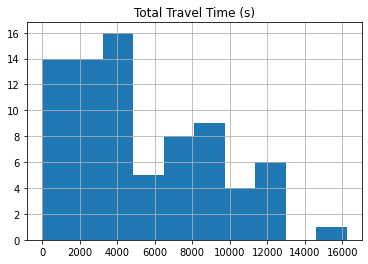

In [110]:
res.hist(column=["Total Travel Time (s)"])

In [130]:
res["Total distance (km)"].sum()

6961.847000000001

In [131]:
res["Total Travel Time (s)"].sum()/(60*60)

110.93111111111111

In [132]:
res["Total Estimated Fuel Consumption (L) (Wong et al.)"].sum()

791.7914703541168

In [124]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_IBEA =[{"mutation":0.5,"crossover":0.2}]

generation_amount = 0
parameter_data_IBEA = []
computation_times_IBEA = []
results_IBEA = []
fronts = []
for index,param in enumerate(parameter_list_IBEA):
    plot_data_IBEA = deepcopy(plot_data_storage_base)
    for x in range(1):
        problem_IBEA = VRP2(data_model_input_multi_objective)
        problem_IBEA.name = "IBEA-A"
        problem_IBEA.assignClosestEndPoint = True
        max_evaluations = 5000

        algorithm_IBEA = Adaptive_IBEA(problem=problem_IBEA,
                                population_size=20,
                                offspring_population_size=20,
                                kappa =0.05,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),
                                   )
        
        performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_IBEA)
        performance_observer_IBEA.maxEpochs= len(parameter_list_IBEA) * 10
        performance_observer_IBEA.currentEpoch = (index*10) + x
         
        
        algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
        algorithm_IBEA.run()
        
        solutions_IBEA = algorithm_IBEA.get_result()
        front_IBEA = get_non_dominated_solutions(solutions_IBEA)
        store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0].path)
        
ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:1 of 10
Evaluations: 5000/5000
Params: {'mutation': 0.5, 'crossover': 0.2} 
IGD:1258.3562414136477
Best fitness: 1210.0435 --- 345.3333                        
Best total fuel consumption:1210.04 
Computing time: 33.82s                        
Average computing speed: 147.83it/s
Current Route:[['V0', 213, 598, 521, 290, 136, 444, 367, 60], ['V1', 568, 491, 260, 183, 106, 337, 414, 63], ['V2', 722, 953, 799, 1030, 645, 1107, 876, 63], ['V3', 473, 319, 88, 165, 242, 396, 550, 63], ['V4', 482, 559, 174, 251, 328, 97, 713, 405, 0], ['V5', 208, 439, 285, 516, 593, 362, 131, 66], ['V6', 470, 316, 239, 547, 393, 162, 701, 85, 64], ['V7', 132, 209, 748, 363, 594, 286, 440, 517, 72], ['V8', 569, 415, 338, 184, 261, 107, 492, 63], ['V9', 182, 798, 413, 490, 259, 105, 336, 567, 63], ['V10', 496, 573, 342, 188, 265, 111, 419, 64], ['V11', 127, 512, 281, 589, 204, 435, 358, 72], ['V12', 100, 177, 408, 485, 254, 562, 331, 60], ['V13', 108, 493, 570, 262, 339, 185, 1032, 416, 63], ['V14', 103, 

In [429]:
res = get_results2(ibea_numerical_path,pd.DataFrame(sigma_distance_matrix),sigma_station_data,meta_data,pd.DataFrame(sigma_time_matrix))
res

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,5.531,3500,0.557448,10.078620,27.732033,718,11:58.00
1,185.374,3500,21.528356,11.613471,64.490375,10348,02:52:28.00
2,185.374,3500,21.528356,11.613471,64.490375,10348,02:52:28.00
3,84.047,3500,10.048490,11.955799,63.153663,4791,01:19:51.00
4,58.812,3569,6.347334,10.792583,51.079180,4145,01:09:05.00
...,...,...,...,...,...,...,...
74,182.885,3084,21.837508,11.940568,71.524823,9205,02:33:25.00
75,4.290,3062,0.437373,10.195180,30.521739,506,08:26.00
76,36.738,1706,4.067730,11.072267,63.462956,2084,34:44.00
77,31.167,1305,3.200908,10.270185,33.343596,3365,56:05.00


In [430]:
res["Total distance (km)"].sum()

7172.648000000001

In [431]:
res["Total Estimated Fuel Consumption (L) (Wong et al.)"].sum()

819.944192643615

array([[<AxesSubplot:title={'center':'Total Travel Time (s)'}>]],
      dtype=object)

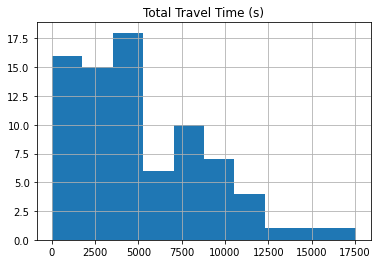

In [439]:
res.hist(column=["Total Travel Time (s)"])

In [125]:
finished_sigma_routes = copy(sigma_routes)
for ind_x, route in enumerate(finished_sigma_routes):
    for ind_y, stop in enumerate(route):
        if (stop +77) in locationNodeIndeces:
            finished_sigma_routes[ind_x][ind_y] = stop + 77
            #fixed_stop = stop + 77  


In [126]:
#[[15, 30], [14, 30], [26, 31], [6, 28, 27, 5, 31], [7, 31], [3, 31], [13, 11, 20, 21, 12, 17, 34], [22, 23, 25, 24, 34], [29, 34], [16, 34], [10, 32], [9, 32], [1, 0, 32], [8, 19], [4, 33], [2, 18]]#[[24, 13, 11, 20, 21, 12, 17, 34], [29, 22, 23, 25, 34], [1, 0, 10, 14, 15, 16, 34], [28, 27, 5, 26, 33], [4, 3, 7, 6, 33], [8, 19], [2, 18], [9, 18]]
#sigma_routes_with_starts = assign_start_pos_to_sigmasol(sigma_routes)#[[30, 24, 13, 11, 20, 21, 12, 17, 34], [30, 29, 22, 23, 25, 34], [32, 1, 0, 10, 14, 15, 16, 34], [31, 28, 27, 5, 26, 33], [31, 4, 3, 7, 6, 33], [18, 8, 19], [18, 2, 18], [32, 9, 18]]
res_sigma = get_results2(finished_sigma_routes,pd.DataFrame(sigma_distance_matrix),sigma_station_data,meta_data,pd.DataFrame(sigma_time_matrix))
res_sigma

<ipython-input-92-082d5a1ddaa2>:17: RuntimeWarning:

invalid value encountered in long_scalars



,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,11.211,500,1.159515,10.342654,29.763717,1356,22:36.00
1,185.374,500,20.672990,11.152044,64.490375,10348,02:52:28.00
2,185.374,500,20.672990,11.152044,64.490375,10348,02:52:28.00
3,84.047,500,9.643644,11.474108,63.153663,4791,01:19:51.00
4,89.020,500,9.572829,10.753571,54.308083,5901,01:38:21.00
...,...,...,...,...,...,...,...
78,256.159,3084,29.144115,11.377354,70.707898,13042,03:37:22.00
79,4.290,3062,0.431045,10.047679,30.521739,506,08:26.00
80,36.738,500,4.003188,10.896587,63.462956,2084,34:44.00
81,4.167,500,0.417055,10.008524,18.917024,793,13:13.00


In [127]:
res_sigma["Total distance (km)"].sum()

8557.689999999997

In [128]:
res_sigma["Total Travel Time (s)"].sum() /(60*60)

130.7838888888889

In [129]:
res_sigma["Total Estimated Fuel Consumption (L) (Wong et al.)"].sum()

961.9988213004865

array([[<AxesSubplot:title={'center':'Total distance (km)'}>]],
      dtype=object)

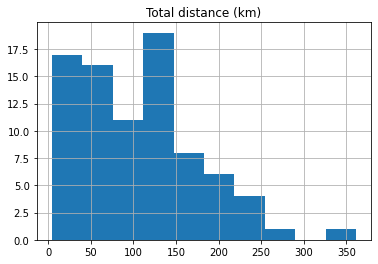

In [103]:
res_sigma.hist(column=["Total distance (km)"])

In [444]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred","lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "white", "pink", "lightblue", "lightgreen", "gray", "black", "lightgray"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route[::-1]:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (sigma_coordinates[stop%77][0],sigma_coordinates[stop%77][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [441]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred","lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "white", "pink", "lightblue", "lightgreen", "gray", "black", "lightgray"]
type_colors=["black","red","green"]
numerical_route = sigma_routes#get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)
for routeNumber,route in enumerate(numerical_route):
    #numerical_route = get_numerical_path(route,vehicles)
    routes = []
    
    for stop in route:
        nodeType = 0
        if stop == route[0]:
            nodeType=2
        elif stop == route[-1]:
            nodeType=1
        coordinates = (sigma_coordinates[stop][0],sigma_coordinates[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    
    
    
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
